### 1. Loading the Data

In these first few cells, we will import necessary packages, load the dataset, and plot some example images.

In [1]:
# Load necessary packages
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# Changing backend from Tensorflow to Theano
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [3]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [4]:
# Let's determine the dataset characteristics
print('Training Images: {}'.format(X_train.shape))
print('Testing Images: {}'.format(X_test.shape))

Training Images: (50000, 32, 32, 3)
Testing Images: (10000, 32, 32, 3)


In [5]:
# Now for a single image 
print(X_train[0].shape)

(32, 32, 3)


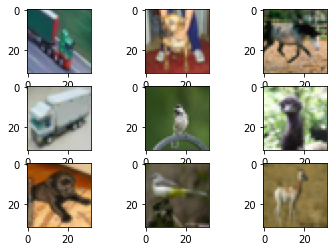

In [6]:
# Create a grid of 3x3 images
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = X_train[50 + i]
    plt.imshow(img)
    
# Show the plot
plt.show()

### 2. Preprocessing the dataset

First things first, we need to preprocess the dataset so the images and labels are in a form that Keras can ingest. To start, we'll define a NumPy seed for reproducibility, then normalize the images. 

Furthermore, we will also convert our class labels to one-hot vectors.  This is a standard output format for neural networks.  

In [7]:
# Building a convolutional neural network for object recognition on CIFAR-10

# Fix random seed for reproducibility
seed = 6
np.random.seed(seed) 

# Load the data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Normalize the inputs from 0 - 255 to 0.0 - 1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [8]:
# Class labels shape
print(Y_train.shape)
print(Y_train[0])

(50000, 1)
[6]


The class labels are a single integer value (0-9).  What we really want is a one-hot vector of length 10.  For example, the class label of 6 should be denoted [0, 0, 0, 0, 0, 0, 1, 0, 0, 0].  We can accomplish this using the `np_utils.to_categorical()` function.

In [9]:
# Hot encode outputs
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
num_classes = Y_test.shape[1]

print(Y_train.shape)
print(Y_train[0])

(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 3. Building the All-CNN

Using the paper as a reference, we can implement the All-CNN network in Keras.  Keras models are built by simply adding layers, one after another. 

To make things easier for us later, we will wrap this model in a function, which will allow us to quickly and neatly generate the model later on in the project. 

Table 1: The ALL-CNN-C network used for classification on CIFAR-10.

Model - C
* Input 32 × 32 RGB image
* 3 × 3 conv. 96 ReLU
* 3 × 3 conv. 96 ReLU
* 3 × 3 max-pooling stride 2
* 3 × 3 conv. 192 ReLU
* 3 × 3 conv. 192 ReLU
* 3 × 3 max-pooling stride 2
* 3 × 3 conv. 192 ReLU
* 1 × 1 conv. 192 ReLU
* 1 × 1 conv. 10 ReLU
* global averaging over 6 × 6 spatial dimensions
* 10 or 100-way softmax

In [20]:
# Start building the model - import necessary layers
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D
from keras.optimizers import SGD

In [24]:
def allcnn(weights = None):
    # Define model type - Sequential
    model = Sequential()

    # Add model layers - Convolution2D, Activation, Dropout
    model.add(Conv2D(96, (3, 3), padding = 'same', input_shape = (32, 32, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3), padding = 'same', strides = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (3, 3), padding = 'same', strides = (2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(192, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1), padding = 'valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding = 'valid'))

    # Add GlobalAveragePooling2D layer with Softmax activation
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    # Load the weights
    if weights:
        model.load_weights(weights)
    
    # Return model
    return model

### 4. Defining Parameters and Training the Model

We are ready to start training our network. In the following cells, we will define our hyper parameters, such as learning rate and momentum, define an optimizer, compile the model, and fit the model to the training data.

In [12]:
# Define hyper parameters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9

# Build model 
model = allcnn()

# Define optimizer and compile model
sgd = SGD(lr = learning_rate, decay = weight_decay, momentum = momentum, nesterov = True)
model.compile(loss ='categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

# Print model summary
print (model.summary())

# Define additional training parameters
epochs = 350
batch_size = 32

# Fit the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = epochs, batch_size = batch_size, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 192)       1

KeyboardInterrupt: 

### 5. Woah, that's a long time...

Uh oh. It's apparent that training this deep convolutional neural network is going to take a long time, which is not surprising considering the network has about 1.3 million parameters. Updating this many parameters takes a considerable amount of time; unless, of course, you are using a Graphics Processing Unit (GPU). This is a good time for a quick lesson on the differences between CPUs and GPUs.  

The **central processing unit (CPU)** is often called the brains of the PC because it handles the majority of necessary computations. All computers have a CPU and this is what Keras and Theano automatically utilize. 

The **graphics processing unit (GPU)** is in charge of image rendering.  The most advanced GPUs were originally designed for gamers; however, GPU-accelerated computing, the use of a GPU together with a CPU to accelarate deep learing, analytics, and engineering applications, has become increasingly common.  In fact, the training of deep neural networks is not realistic without them. 

The most common GPUs for deep learning are produced by NVIDIA.  Furthermore, the NVIDIA Deep Learning SDK provides high-performance tools and libraries to power GPU-accelerated machine learning applications. An alternative would be an AMD GPU in combination with the OpenCL libraries; however, these libraries have fewer active users and less support than the NVIDIA libraries. 

If your computer has an NVIDIA GPU, installing the CUDA Drivers and CUDA Tookit from NVIDIA will allow Theano and Keras to utilize GPU-accelerated computing. The original paper mentions that it took approximately 10 hours to train the All-CNN network for 350 epochs using a modern GPU, which is considerably faster (several orders of magnitude) than it would take to train on CPU. 

If you haven't already, stop the cell above. In the following cells, we'll save some time by loading pre-trained weights for the All-CNN network. Using these weights, we can evaluate the performance of the All-CNN network on the testing dataset.

In [25]:
# Define hyper parameters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9

# Define weights and build model
weights = 'all_cnn_weights_0.9088_0.4994.hdf5'
model = allcnn(weights)

# Define optimizer and compile model
sgd = SGD(lr = learning_rate, decay = weight_decay, momentum = momentum, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

# Print model summary
print (model.summary())

# Test the model with pretrained weights
scores = model.evaluate(X_test, Y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_50 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 192)      

### 6. Making Predictions

Using the pretrained weights, we were able to achieve an accuracy of nearly 90 percent! Let's leverage this network to make some predictions. To start, we will generate a dictionary of class labels and names by referencing the website for the CIFAR-10 dataset:

https://www.cs.toronto.edu/~kriz/cifar.html

Next, we'll make predictions on nine images and compare the results to the ground-truth labels.  Furthermore, we will plot the images for visual reference, this is object recognition after all.

In [26]:
# Make dictionary of class labels and names
classes = range(0,10)

names = ['airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck']

# Zip the names and classes to make a dictionary of class labels
class_labels = dict(zip(classes, names))

# Generate batch of 9 images to predict
batch = X_test[100 : 109]
labels = np.argmax(Y_test[100:109], axis =- 1)

# Make predictions
predictions = model.predict(batch, verbose = 1)

1/1 [==============================] - 0s 1ms/step


In [28]:
# print our predictions
print (predictions)

[[4.5647234e-18 1.0580984e-20 1.8923278e-10 2.1411404e-11 9.9999928e-01
  2.8037445e-07 3.1478666e-13 4.2381367e-07 1.3699609e-19 1.2097066e-18]
 [2.1190902e-16 2.0386702e-17 1.5672676e-09 5.3581510e-07 1.6256110e-10
  9.9999940e-01 1.6712491e-09 2.0782188e-08 3.6548193e-15 3.5128330e-16]
 [1.2720419e-30 5.0273835e-28 5.1540022e-24 3.6051407e-21 1.0875223e-27
  8.1522466e-22 1.0000000e+00 1.1050908e-27 6.1924619e-32 1.2274333e-23]
 [1.5143829e-16 4.7668872e-18 2.2583695e-09 1.0000000e+00 4.3481212e-11
  1.6884210e-12 4.5317211e-13 2.6687057e-16 7.2659426e-19 6.2049941e-17]
 [8.2502348e-36 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 9.3568045e-36 8.6868626e-30 8.2192576e-22]
 [5.9699731e-24 1.0000000e+00 7.5485268e-27 8.0228679e-27 1.9714101e-30
  2.7338925e-29 7.2188490e-31 5.5680368e-27 1.6186991e-26 1.1906196e-13]
 [6.4563548e-18 2.9642424e-20 1.0046495e-11 9.9999988e-01 6.0155900e-13
  9.1111154e-08 7.8874641e-12 1.1608701e-15 7.8587764e-21 

In [29]:
# These are individual class probabilities, should sum to 1.0 (100%)
for image in predictions:
    print(np.sum(image))

1.0
0.99999994
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [31]:
# Use np.argmax() to convert class probabilities to class labels
class_result = np.argmax(predictions,axis =- 1)
print (class_result)

[4 5 6 3 1 1 3 6 8]


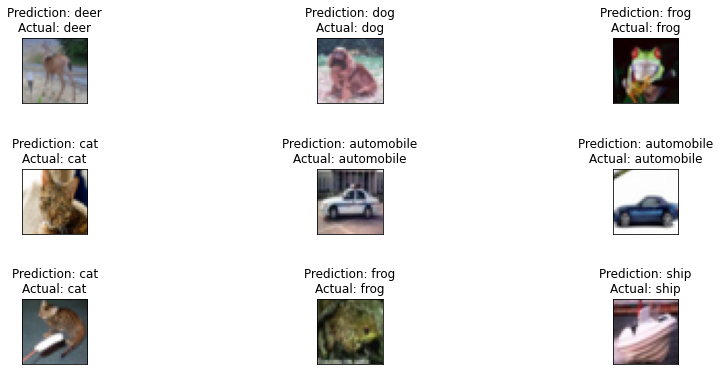

In [32]:
# Create a grid of 3x3 images
fig, axs = plt.subplots(3, 3, figsize = (15, 6))
fig.subplots_adjust(hspace = 1)
axs = axs.flatten()

for i, img in enumerate(batch):

    # Determine label for each prediction, set title
    for key, value in class_labels.items():
        if class_result[i] == key:
            title = 'Prediction: {}\nActual: {}'.format(class_labels[key], class_labels[labels[i]])
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
            
    # Plot the image
    axs[i].imshow(img)
    
# Show the plot
plt.show()